In [14]:
#Process docking results and correlate RMSD with chemical features of molecules
#11/13/23 added an update- Spearman correlation
#Hoping to obtain a file of protein features/P-L complex features, which can also be correlated with RMSD
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem, GetPeriodicTable, RemoveHs
from rdkit.Chem import Descriptors
from rdkit.Chem import rdDistGeom
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats
import copy

In [2]:
pdbpath = "/Users/dsharon/Documents/MIT/6.8701/Project/Code/HarmonicFlow/FlowSite/data/PDBBind_processed/"
name_info = ["6oxr"]

In [3]:
#Copied from https://github.com/gcorso/DiffDock/blob/main/datasets/process_mols.py
def read_molecule(molecule_file, sanitize=False, calc_charges=False, remove_hs=False):
    if molecule_file.endswith('.mol2'):
        mol = Chem.MolFromMol2File(molecule_file, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.sdf'):
        supplier = Chem.SDMolSupplier(molecule_file, sanitize=False, removeHs=False)
        mol = supplier[0]
    elif molecule_file.endswith('.pdbqt'):
        with open(molecule_file) as file:
            pdbqt_data = file.readlines()
        pdb_block = ''
        for line in pdbqt_data:
            pdb_block += '{}\n'.format(line[:66])
        mol = Chem.MolFromPDBBlock(pdb_block, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.pdb'):
        mol = Chem.MolFromPDBFile(molecule_file, sanitize=False, removeHs=False)
    else:
        raise ValueError('Expect the format of the molecule_file to be '
                         'one of .mol2, .sdf, .pdbqt and .pdb, got {}'.format(molecule_file))

    try:
        if sanitize or calc_charges:
            Chem.SanitizeMol(mol)

        if calc_charges:
            # Compute Gasteiger charges on the molecule.
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                warnings.warn('Unable to compute charges for the molecule.')

        if remove_hs:
            mol = Chem.RemoveHs(mol, sanitize=sanitize)
    except Exception as e:
        print(e)
        print("RDKit was unable to read the molecule.")
        return None

    return mol

In [4]:
#Pull sdf/mol2 and then smiles
for pdb_name in name_info:

    #Copied below from https://github.com/gcorso/DiffDock/blob/main/datasets/pdbbind.py
    for file in os.listdir(os.path.join(pdbpath, pdb_name)):
        if file.endswith(".sdf") and 'rdkit' not in file:
            lig = read_molecule(os.path.join(pdbpath, pdb_name, file), remove_hs=False, sanitize=True)
            if lig is None and os.path.exists(os.path.join(pdbpath, pdb_name, file[:-4] + ".mol2")):  # read mol2 file if sdf file cannot be sanitized
                print('Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.')
                lig = read_molecule(os.path.join(pdbpath, pdb_name, file[:-4] + ".mol2"), remove_hs=False, sanitize=True)


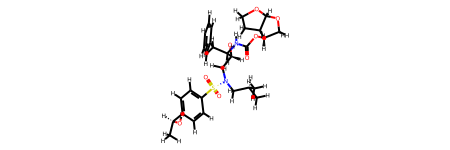

In [5]:
lig

In [9]:
#ref https://iwatobipen.wordpress.com/2021/01/31/generate-conformers-script-with-rdkit-rdkit-chemoinformatics/
param = rdDistGeom.ETKDGv2()
#param.pruneRmsThresh = prunermsthresh
cids = rdDistGeom.EmbedMultipleConfs(lig, 20, param)
mp = AllChem.MMFFGetMoleculeProperties(lig, mmffVariant='MMFF94s')
AllChem.MMFFOptimizeMoleculeConfs(lig, numThreads=0, mmffVariant='MMFF94s')

[(1, -2.186651820492152),
 (1, -1.7213061832853302),
 (1, -7.565614995064319),
 (1, -0.798321176798396),
 (1, -3.7722802682662024),
 (1, -10.195510274288932),
 (1, -5.497278120553453),
 (1, -7.321390542226727),
 (1, -0.8599793657862751),
 (1, -7.9214133227418895),
 (1, -0.9256121332081593),
 (1, -3.2856425812912624),
 (1, -8.23726995342548),
 (1, -12.95859292039647),
 (1, -8.143452374521324),
 (1, -4.743661016713163),
 (1, 1.8467775921926073),
 (1, -4.783701327530315),
 (1, 6.184672383737393),
 (1, -6.47346315426011)]

In [12]:
cids[1]

1

In [22]:
#Ref https://github.com/gcorso/DiffDock/blob/main/datasets/process_mols.py copied
#Ref https://greglandrum.github.io/rdkit-blog/posts/2023-02-04-working-with-conformers.html copied
for i in range(20):
    #mol_rdkit = copy.deepcopy(lig)

    #mol_rdkit.RemoveAllConformers()
    #mol_rdkit = AllChem.AddHs(mol_rdkit)
    #generate_conformer(mol_rdkit)
    #if remove_hs:
    #    mol_rdkit = RemoveHs(mol_rdkit, sanitize=True)
    #mol = copy.deepcopy(mol_maybe_noh)
    #if rotable_bonds:
    #    optimize_rotatable_bonds(mol_rdkit, mol, rotable_bonds, popsize=popsize, maxiter=maxiter)
    #mol.AddConformer(mol_rdkit.GetConformer())
    #rms_list = []
    #AllChem.AlignMolConformers(mol, RMSlist=rms_list)
    #mol_rdkit.RemoveAllConformers()
    #mol_rdkit.AddConformer(lig.GetConformers()[i])
    print(lig.GetConformers()[i].GetPositions())
    print("--------")

[[ 1.63627453 -0.97936819  0.25551423]
 [-4.48145807  2.79093107 -0.37433626]
 [-5.03562985  3.7373107  -1.42373394]
 [-5.72045761  2.01685903  0.0308821 ]
 [-6.15121888  0.87285091 -0.87537069]
 [ 6.46938689  1.18271707 -0.51195973]
 [ 6.37795129  1.00177838  0.87860461]
 [ 5.14176324  1.05171012  1.52593661]
 [ 3.97927581  1.24633427  0.7772535 ]
 [ 4.0528356   1.45855945 -0.6024938 ]
 [ 5.29383996  1.41597266 -1.24319261]
 [ 2.60010881 -1.24022177  2.53506518]
 [ 1.73123552 -1.7134519   3.71290299]
 [ 0.52586993 -0.36498687 -0.61949612]
 [-0.88106377 -0.3821909   0.03718008]
 [-2.75647857  1.24182631 -0.01142603]
 [-6.82377749  3.04952999 -0.11354844]
 [-7.4436721   1.34463215 -1.51007816]
 [-1.53333354 -1.78059268  0.19545359]
 [-2.1050074  -2.42736977 -1.04856554]
 [-3.39067643 -2.09042254 -1.49504366]
 [-3.93311028 -2.68633269 -2.63352729]
 [-3.19634967 -3.63453078 -3.33921241]
 [-1.92011556 -3.98630514 -2.90290964]
 [-1.37941514 -3.39049441 -1.7618069 ]
 [ 8.11510961 -0.34555141

AttributeError: 'Mol' object has no attribute 'atoms'